# JH & G COVID Data Model

Experimenting with the John Hopkins dataset and Google Mobility Reports to see if a useful model can be created 

In [869]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D #to define a custom legend
#import matplotlib.ticker as ticker #to set vertical gridline spacing
#import matplotlib.dates as mdates #use dates on x-axis labels
import seaborn as sns

import datetime

# Feature Engineering
from scipy.signal import savgol_filter

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

# Model prep
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# Algorithms
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.linear_model import SGDRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor

# Evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Read in data

In [646]:
dfJ_import = pd.read_csv('JH_2020-05-12.csv')
dfG = pd.read_csv('Global_Mobility_Report_2020-05-12.csv', sep=',', low_memory=False)

#dfJ.head()
#dfG.head()

## Rearrange John Hopkins data

The John Hopkins dataset is not in 'Tidy Format' so here I have crudely manipulated it into a more useful format

In [647]:
#dfJ_import = pd.read_csv('JH_2020-04-28.csv')
dfJ_import.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,85,90,95,104,106,109,115,120,122,127
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,31,31,31,31,31,31,31,31,31,31
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,463,465,470,476,483,488,494,502,507,515
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,45,45,46,46,47,47,48,48,48,48
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2


Get a list of contries with country level data (i.e. no Province/State data)

In [648]:
index = pd.isnull(dfJ_import[['Province/State']]).any(1).to_numpy().nonzero()[0]

And split the imported dataset into country level data (dfJ_t) and remaining, 'Province/State', data (dfJ_import_r)

In [649]:
temp = pd.DataFrame()

dfJ_t = dfJ_import.loc[index,:]
dfJ_import_r = dfJ_import.drop(index)

dfJ_t = dfJ_t.drop(columns = ['Province/State', 'Lat', 'Long']) #Not using these columns so drop them
dfJ_t.head()

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20
0,Afghanistan,0,0,0,0,0,0,0,0,0,...,85,90,95,104,106,109,115,120,122,127
1,Albania,0,0,0,0,0,0,0,0,0,...,31,31,31,31,31,31,31,31,31,31
2,Algeria,0,0,0,0,0,0,0,0,0,...,463,465,470,476,483,488,494,502,507,515
3,Andorra,0,0,0,0,0,0,0,0,0,...,45,45,46,46,47,47,48,48,48,48
4,Angola,0,0,0,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2


If there is no country level data available for a 'State/Province' (e.g. China where the data is broken down to each individual state), sum the available data and append the Country onto dfJ, otherwise create a new 'Country/Region' to group all these 'State/Province's

In [650]:
stateCountries = dfJ_import_r['Country/Region'].unique()

temp = pd.DataFrame(columns = dfJ_t.columns)

for x in stateCountries:
    
    if x in dfJ_t['Country/Region'].unique():
    
        temp.loc[0,'Country/Region'] = x + ' Overseas Territories' 
        #Apologies if 'Overseas Territories' is not an appropriate term in some cases.
        #I've used it because 'British Overseas Territories' is the general term used for the UK countries so I've generalised
    else:
        temp.loc[0,'Country/Region'] = x
    
    for y in dfJ_t.columns[1:]:
        temp.loc[0,y] = sum(dfJ_import_r[dfJ_import_r['Country/Region'] == x][y])
    
    dfJ_t = dfJ_t.append(temp, ignore_index=True)

'Rotate' the data so that it's in 'Tidy Format' 

In [651]:
variable = dfJ_t['Country/Region'].values
dfJ = pd.DataFrame(columns = variable)
dfJ.reset_index()
#n_dfJ.drop(columns='Country/Region')
dfJ['Date'] = dfJ_t.columns[1:]

for x in dfJ.columns[0:-1]:
    
    dfJ_index, = np.where(dfJ_t['Country/Region'][:].values == x)[0]
    dfJ.loc[:,x] = dfJ_t.iloc[dfJ_index][1:].values

### Reorder so Date is the first column in the Data Frame
temp = dfJ.pop('Date')
dfJ.insert(0, 'Date', temp)

The 'Diamond Princess' isn't a country so... Remove it. 

More seriously, in most countries the number of infections are vastly lower than the total population. This wasn't the case on the Diamond Princess so I believe it could be tricky data to interpret

In [652]:
dfJ = dfJ.drop(columns = 'Diamond Princess')

Specify that 'Date' is in datetime format

In [653]:
dfJ["Date"] = pd.to_datetime(dfJ["Date"], format='%m/%d/%y')
#dfJ

## Update Google Data

Google's Mobility Report data is in tidy format so only small changes are needed:

Rename columns to be consistent

In [654]:
dfG = dfG.rename(columns={"country_region": "Country", "date": "Date"})

And specify that the dates are datetime format

In [655]:
dfG["Date"] = pd.to_datetime(dfG["Date"])#, format='%d/%m/%Y')

#dfG.dtypes

# Remove unnecessary / unused columns

## John Hopkins data

### Rename headers

As this data will be merged with Google's, it's important countries have exactly the same names

In [656]:
dfJ = dfJ.rename(columns={"US": "USA", "Taiwan*":"Taiwan"})

### Remove countries with a 'small' number of cases

In [657]:
limitCount = 3000 # minimum count to not be discounted

lowDeaths = pd.DataFrame()
for x in list(dfJ.columns[1:]): #Starts at 1 to ignore 'Date'
    if max(dfJ[x][:])<=limitCount:
        temp = dfJ.pop(x)
        lowDeaths[temp.name] = temp

#dfJ.head()
#lowDeaths.head()

### Change to 'tidy' format

In [658]:
minD = 100 #Data for number of deaths <100 can be noisy so this step removes it (see loop below)

dayVal = 'Day_' + str(minD)

trimmedDf = pd.DataFrame(columns = [dayVal, 'Country', 'Deaths'])

temp = pd.DataFrame()#columns = ['Day_0', 'Country', 'Deaths'])
#for loop loops through countries. Skips index 0 as that's the date (not a country...)
for x in list(dfJ.columns[1:]):
    
    #Data for number of deaths <100 can be noisy so this step removes it
    for y in dfJ.index:
        if dfJ.loc[y,x] < minD:
            dfJ.loc[y,x] = 0
        else:
            break

    
    nonZero = dfJ[x].to_numpy().nonzero()
    firstVal = nonZero[0][0]
    tempList = list(dfJ[x][firstVal:])
    
    temp[dayVal] = range(1,len(tempList)+1)
    temp['Country'] = [x] * (len(tempList))
    temp['Date'] = list(dfJ['Date'][firstVal:])
    temp['Deaths'] = tempList
    
    trimmedDf = trimmedDf.append(temp, ignore_index=True, sort=True)
    temp = temp.iloc[0:0] #reset temp

dfJ = trimmedDf.copy()
dfJ[dayVal] = dfJ[dayVal].astype(int) #Set variables as integers   
del trimmedDf, temp
dfJ.head()

,Country,Date,Day_100,Deaths
0,Belgium,2020-03-24,1,122
1,Belgium,2020-03-25,2,178
2,Belgium,2020-03-26,3,220
3,Belgium,2020-03-27,4,289
4,Belgium,2020-03-28,5,353


## Google data
We're only using the country level data, so removing sub-regions 

In [659]:
dfG = dfG.drop(dfG.index[pd.notna(dfG['sub_region_1'])]) # Remove all not-empty subregion rows
dfG = dfG.drop(columns=['sub_region_1', 'sub_region_2', 'country_region_code']) # Remove unnecessary columns

### Rename Countries

As this data will be merged with John Hopkins' it's important that countries are named consistently

In [660]:
dfG.loc[(dfG['Country'] == 'United States'),'Country'] = 'USA'

### Rename headers
Just to neaten things up for later (when plotting anything), I'm shortening the column titles

In [661]:
dfG = dfG.rename(columns={"retail_and_recreation_percent_change_from_baseline": "Retail and Recreation",
                          "grocery_and_pharmacy_percent_change_from_baseline":"Grocery and Pharmacy", 
                          "parks_percent_change_from_baseline":"Parks", 
                          "transit_stations_percent_change_from_baseline":"Transit Stations", 
                          "workplaces_percent_change_from_baseline":"Workplaces",
                          "residential_percent_change_from_baseline": "Residential"})

#dfG.head()

# Feature 'Engineering'
Turning the features into something more useful

I do this before merging the John Hopkins and Google datasets because you lose a few dates when you merge the data

## Calculate the number of new deaths per day

In [662]:
dfJ['dDeaths'] = np.nan
for x in dfJ['Country'].unique(): #Loop through all unique countries
    indexList = dfJ[dfJ.Country == x]['Deaths'].index.values.astype(int)
    
    #Leading zeros have been removed so: 
    #dfJ.loc[min(indexList),'dDeaths'] = dfJ.loc[min(indexList), 'Deaths'] 
    # IGNORED AS ALL VALUES BELOW 100 HAVE BEEN REMOVED 
    
    #Assumes data is still in chronological order!    
    for y in range((min(indexList)+1),(max(indexList)+1)): #Loop through all entries for that country
        dfJ.loc[y, 'dDeaths'] = dfJ.loc[y, 'Deaths'] - dfJ.loc[(y-1), 'Deaths']
        
        #Some countries have abruptly revised upwards their estimates of death. 
        #To avoid introducing a random peak in the data, I've added this check to replace the value with the average of the one before and after
        if dfJ.loc[y, 'dDeaths'] > 1000 and dfJ.loc[y, 'dDeaths'] > 100 * abs(dfJ.loc[y-1, 'dDeaths']):
            dfJ.loc[y, 'dDeaths'] = ((dfJ.loc[y-1, 'dDeaths']) + (dfJ.loc[y+1, 'Deaths'] - dfJ.loc[(y), 'Deaths']))/2
      

dfJ = dfJ.dropna().reset_index(drop = True) #Remove NaNs left from the first row for each country
dfJ['dDeaths'] = dfJ['dDeaths'].dropna().astype(int)        
dfJ.head()

,Country,Date,Day_100,Deaths,dDeaths
0,Belgium,2020-03-25,2,178,56
1,Belgium,2020-03-26,3,220,42
2,Belgium,2020-03-27,4,289,69
3,Belgium,2020-03-28,5,353,64
4,Belgium,2020-03-29,6,431,78


### Pass this through a filter to remove the 'noise'

The JH data presents the number of new deaths reported by the government on a day, but not the date it they actually occur. Therefore there is a bit of 'noise' on this data as reporting increases and decreases during a working week. 

Filtering this aims to remove this 'noise'.

In [663]:
dfJ['dDeaths_filtered'] = np.nan
for x in dfJ['Country'].unique(): #Loop through all unique countries
    
    indexList = dfJ[dfJ.Country == x]['dDeaths'].index.values.astype(int)
    
    #dfJ['dDeaths_filtered'][min(indexList):(max(indexList)+1)] = savgol_filter(dfJ[dfJ.Country == x]['dDeaths'], 15, 3)
    #dfJ.loc[min(indexList):(max(indexList)),'dDeaths_filtered'] = savgol_filter(dfJ[dfJ.Country == x]['dDeaths'], 15, 3)
    dfJ.loc[indexList,'dDeaths_filtered'] = savgol_filter(dfJ[dfJ.Country == x]['dDeaths'], 15, 3)
        
#dfJ['dDeaths_filtered'] = dfJ['dDeaths_filtered'].astype(float)
#dfJ['dDeaths_filtered']
#savgol_filter(dfJ[dfJ.Country == 'Belgium']['dDeaths'], 15, 3)
dfJ.head()

,Country,Date,Day_100,Deaths,dDeaths,dDeaths_filtered
0,Belgium,2020-03-25,2,178,56,42.170588
1,Belgium,2020-03-26,3,220,42,55.067647
2,Belgium,2020-03-27,4,289,69,67.347059
3,Belgium,2020-03-28,5,353,64,79.310860
4,Belgium,2020-03-29,6,431,78,91.261086


### Normalise it by the total deaths

In [664]:
dfJ['dDeaths_f/total'] = dfJ['dDeaths_filtered'] / dfJ['Deaths']

## Calculate the rate of change of new reported deaths

In [665]:
dfJ['dd_Deaths'] = np.nan
for x in dfJ['Country'].unique(): #Loop through all unique countries
    
    indexList = dfJ[dfJ.Country == x]['dDeaths'].index.values.astype(int)
    
    dfJ.loc[indexList[0],'dd_Deaths'] = dfJ.loc[indexList[0], 'dDeaths_filtered']
    for y in indexList[1:]:
        dfJ.loc[y,'dd_Deaths'] = dfJ.loc[y, 'dDeaths_filtered'] - dfJ.loc[y-1, 'dDeaths_filtered']

#dfJ.head()

And filter this data as well

In [666]:
dfJ['dd_Deaths_filtered'] = np.nan
for x in dfJ['Country'].unique(): #Loop through all unique countries
    
    indexList = dfJ[dfJ.Country == x]['dd_Deaths'].index.values.astype(int)
    
    #dfJ['dDeaths_filtered'][min(indexList):(max(indexList)+1)] = savgol_filter(dfJ[dfJ.Country == x]['dDeaths'], 15, 3)
    #dfJ.loc[min(indexList):(max(indexList)),'dDeaths_filtered'] = savgol_filter(dfJ[dfJ.Country == x]['dDeaths'], 15, 3)
    dfJ.loc[indexList,'dd_Deaths_filtered'] = savgol_filter(dfJ[dfJ.Country == x]['dd_Deaths'], 11, 3)
        
#dfJ['dDeaths_filtered'] = dfJ['dDeaths_filtered'].astype(float)
#dfJ['dDeaths_filtered']
#savgol_filter(dfJ[dfJ.Country == 'Belgium']['dDeaths'], 15, 3)
dfJ.head()

,Country,Date,Day_100,Deaths,dDeaths,dDeaths_filtered,dDeaths_f/total,dd_Deaths,dd_Deaths_filtered
0,Belgium,2020-03-25,2,178,56,42.170588,0.236913,42.170588,34.818859
1,Belgium,2020-03-26,3,220,42,55.067647,0.250307,12.897059,23.155286
2,Belgium,2020-03-27,4,289,69,67.347059,0.233035,12.279412,15.310334
3,Belgium,2020-03-28,5,353,64,79.310860,0.224677,11.963801,10.710603
4,Belgium,2020-03-29,6,431,78,91.261086,0.211743,11.950226,8.782692


And divide by dDeaths_filtered to 'Normalise' it

In [667]:
dfJ['dd_Deaths_f/dDeaths_f'] = dfJ['dd_Deaths_filtered'] / dfJ['dDeaths_filtered']
#dfJ[dfJ.Country == 'France'][0:30]

# Merge Data

## Pre-Merge Feature Engineering
Google's dataset should be in some way proportional to the daily infections. I'm also assuming the number of deaths is (roughly) proportional to the number of infections. 

However, deaths do not occur on the same day as an infection but are offset. So, I'm assuming a 21 day offset

In [668]:
dayOffset = 21
dfG_offset = dfG.copy()
dfG_offset['Date'] = dfG['Date'] + datetime.timedelta(days=dayOffset)
#I label this dfG_offset because I occasionally check which offset generates the best model. 
#It's unhelpful having to re-run absolutely everything 

## Merging

In [669]:
df = pd.merge(dfJ, dfG_offset, on=['Country', 'Date'])
df.head()

,Country,Date,Day_100,Deaths,dDeaths,dDeaths_filtered,dDeaths_f/total,dd_Deaths,dd_Deaths_filtered,dd_Deaths_f/dDeaths_f,Retail and Recreation,Grocery and Pharmacy,Parks,Transit Stations,Workplaces,Residential
0,Belgium,2020-03-25,2,178,56,42.170588,0.236913,42.170588,34.818859,0.825667,1.0,4.0,7.0,1.0,4.0,0.0
1,Belgium,2020-03-26,3,220,42,55.067647,0.250307,12.897059,23.155286,0.420488,-4.0,1.0,-16.0,-2.0,2.0,2.0
2,Belgium,2020-03-27,4,289,69,67.347059,0.233035,12.279412,15.310334,0.227335,-1.0,5.0,2.0,3.0,2.0,1.0
3,Belgium,2020-03-28,5,353,64,79.310860,0.224677,11.963801,10.710603,0.135046,5.0,3.0,33.0,8.0,2.0,0.0
4,Belgium,2020-03-29,6,431,78,91.261086,0.211743,11.950226,8.782692,0.096237,-1.0,1.0,-21.0,-2.0,-1.0,0.0


# Prepare the data for the ML model
## Remove identifiers (i.e. anything that is not a feature)
We will remove any feature that is not used for creating the model and will get in the way
(Note, I will keep Country to better get a random set later on...)

In [670]:
#Runs for 'dDeaths_filtered', and 'dDeaths_f/total'
feature = 'dd_Deaths_f/dDeaths_f'
dataset = df[["Retail and Recreation", "Grocery and Pharmacy", 
             "Parks", "Transit Stations", "Workplaces", 
             "Residential", feature, "Country"]] # Country included to split test and train data

## Split out the target feature
In this case, 'Deaths'

In [671]:
Y = dataset[[feature, "Country"]]
X = dataset.loc[:, dataset.columns != feature]

### Split to train and test sets

In [704]:
test_size = 0.33 #has to be between 0 and 1
seed = 1 #Any integer. This one happens to select the UK as a test country...

testCountries = pd.Series(X['Country'].unique()).sample(frac = test_size, random_state = seed) # randomly select a fraction of the countries

#testCountries = pd.Series('United Kingdom')


X_train_orig = X
Y_train = Y
X_test_orig = pd.DataFrame()
Y_test = pd.DataFrame()
for x in testCountries: #Loop through 'test' countries
    #I cannot pop() ranges of rows so, create a copy (append) the rows associated with a 'test' country
    #And then drop those rows
    X_test_orig = X_test_orig.append(X_train_orig[X_train_orig.Country == x])
    X_train_orig = X_train_orig.drop(X_train_orig[X_train_orig.Country == x].index)
    
    Y_test = Y_test.append(Y_train[Y_train.Country == x])
    Y_train = Y_train.drop(Y_train[Y_train.Country == x].index)

In [705]:
# Removing the 'Country' feature from the models
#X_train_orig = X_train_orig.drop(columns = 'Country')
#X_test_orig = X_test_orig.drop(columns = 'Country')
Y_train = Y_train[feature]
Y_test = Y_test[feature]

I don't fully understand why, but sklearn strongly suggest you rescale the X values after splitting. Given my assumption is that this basically just rescales the inputs to between +/-1 (or 0-1), I'm not sure why this is necessary

In [706]:
scaler = StandardScaler()
scaler.fit(X_train_orig.drop(columns = 'Country'))
X_train = scaler.transform(X_train_orig.drop(columns = 'Country'))
X_test = scaler.transform(X_test_orig.drop(columns = 'Country'))

While the model is capable of taking all features as an input, this is an interesting assessment as to which are the most valuable

In [707]:
#X = selectFeaturesKBestRegression(2, X, Y)
k = 3
score_func = f_regression

#From Daisy library
test = SelectKBest(score_func=score_func, k=k)
    #fit = test.fit(X,Y.iloc[:,0].tolist())
fit = test.fit(X.loc[:, X.columns != 'Country'],Y[feature].tolist())
    #set_printoptions(precision=3)
    #print(fit.scores_)
features = fit.transform(X.loc[:, X.columns != 'Country'])
    #print(features[0:k+1,:])
selected_cols = test.get_support()
    #print(selected_cols)        
    
    #Now pull out the feature names that match
selected_features = []
for i in range(len(selected_cols)):
    if selected_cols[i]:
        selected_features.append(X.columns[i])
    #print(selected_features)   
    
X[selected_features]

,Retail and Recreation,Transit Stations,Workplaces
0,1.0,1.0,4.0
1,-4.0,-2.0,2.0
2,-1.0,3.0,2.0
3,5.0,8.0,2.0
4,-1.0,-2.0,-1.0
...,...,...,...
656,-53.0,-67.0,-59.0
657,-54.0,-57.0,-40.0
658,-60.0,-64.0,-42.0
659,-46.0,-65.0,-58.0


## Train the models

In [875]:
algorithms = []
algorithms.append(LinearRegression())
algorithms.append(KNeighborsRegressor())
algorithms.append(DecisionTreeRegressor())
algorithms.append(SVR(gamma = 'scale', kernel='linear'))
algorithms.append(SGDRegressor(loss="squared_loss"))
algorithms.append(GaussianProcessRegressor(normalize_y=True))
algorithms.append(MLPRegressor(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,solver='lbfgs'))
#algorithms.append(LinearSVR())

In [876]:
modelResults = []

# Split into 10 folds
kfold = KFold(n_splits=10, random_state=seed)

modelResults = pd.DataFrame(columns = ['Algorithm Name', 'Result', 'Algorithm'])
x=0

# Perform 10-fold CV on all algorithms
for algorithm in algorithms:
    cv_results = cross_val_score(algorithm, X_train, Y_train, cv=kfold, scoring='neg_mean_squared_error')#'neg_mean_absolute_error')
    #modelResults.append([algorithm.__name__, -cv_results.mean()])
    modelResults = modelResults.append({"Algorithm Name":algorithm.__class__.__name__, 'Result':-cv_results.mean(), "Algorithm":algorithm},ignore_index=True)
modelResults

,Algorithm Name,Result,Algorithm
0,LinearRegression,0.025684,"LinearRegression(copy_X=True, fit_intercept=Tr..."
1,KNeighborsRegressor,0.038322,"KNeighborsRegressor(algorithm='auto', leaf_siz..."
2,DecisionTreeRegressor,0.048649,"DecisionTreeRegressor(criterion='mse', max_dep..."
3,SVR,0.024892,"SVR(C=1.0, cache_size=200, coef0=0.0, degree=3..."
4,SGDRegressor,0.024646,"SGDRegressor(alpha=0.0001, average=False, earl..."
5,GaussianProcessRegressor,38.657406,"GaussianProcessRegressor(alpha=1e-10, copy_X_t..."
6,MLPRegressor,0.025796,"MLPRegressor(activation='relu', alpha=1e-05, b..."


## Select the most promising models and assess against the test data
To (try to) avoid selecting an over-fitted model, I loop through the best models and check all of them against the Test Data. 

Inefficient, but with a small dataset, not a massive issue

In [877]:
modelResults['Test Result'] = np.nan
bestIndex = modelResults['Result'].idxmin()
bestResult = modelResults['Result'][bestIndex]

for x in modelResults.index:
    altModel = modelResults['Result'][x]
    
    if altModel < 1.1 * bestResult:
        model = modelResults['Algorithm'][x]        
        model.fit(X_train, Y_train)
        predictions = model.predict(X_test)
        modelResults.loc[x,'Test Result'] = mean_squared_error(Y_test, predictions)
modelResults

,Algorithm Name,Result,Algorithm,Test Result
0,LinearRegression,0.025684,"LinearRegression(copy_X=True, fit_intercept=Tr...",0.012858
1,KNeighborsRegressor,0.038322,"KNeighborsRegressor(algorithm='auto', leaf_siz...",NaN
2,DecisionTreeRegressor,0.048649,"DecisionTreeRegressor(criterion='mse', max_dep...",NaN
3,SVR,0.024892,"SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...",0.012809
4,SGDRegressor,0.024646,"SGDRegressor(alpha=0.0001, average=False, earl...",0.013467
5,GaussianProcessRegressor,38.657406,"GaussianProcessRegressor(alpha=1e-10, copy_X_t...",NaN
6,MLPRegressor,0.025796,"MLPRegressor(activation='relu', alpha=1e-05, b...",0.013064


In [878]:
bestAlgorithm = modelResults['Algorithm'][modelResults['Test Result'].idxmin()]
model = bestAlgorithm
#model = LinearRegression()
model = SVR(gamma = 'scale', kernel='linear')
#model = SGDRegressor(loss="squared_loss")
#model = MLPRegressor(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,solver='lbfgs')
model.fit(X_train, Y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [879]:
### Duplicate to be deleted
predictions = model.predict(X_test)
print(mean_squared_error(Y_test, predictions)) #mean_absolute_error

0.01280935770918449


# Compare with original data

In [880]:
comparison = X_test_orig.copy()
comparison['Prediction'] = predictions
#comparison['Original'] = Y_test
googleDataHeaders = ["Retail and Recreation", "Grocery and Pharmacy", 
                     "Parks", "Transit Stations", "Workplaces", "Residential"]

df_output = pd.merge(df, comparison, on=(googleDataHeaders + ["Country"]))
df_output

,Country,Date,Day_100,Deaths,dDeaths,dDeaths_filtered,dDeaths_f/total,dd_Deaths,dd_Deaths_filtered,dd_Deaths_f/dDeaths_f,Retail and Recreation,Grocery and Pharmacy,Parks,Transit Stations,Workplaces,Residential,Prediction
0,France,2020-03-17,2,148,0,-12.576797,-0.0849784,-12.576797,0.030239,-0.002404,1.0,1.0,23.0,-3.0,-14.0,4.0,0.183233
1,France,2020-03-18,3,148,0,40.388189,0.272893,52.964986,29.372007,0.727242,-5.0,-2.0,9.0,-5.0,-12.0,3.0,0.181704
2,France,2020-03-19,4,243,95,84.274528,0.346809,43.886339,43.324128,0.514083,-5.0,-1.0,1.0,-5.0,-15.0,4.0,0.194412
3,France,2020-03-20,5,450,207,120.644940,0.2681,36.370412,45.516678,0.377278,-1.0,1.0,15.0,0.0,-15.0,4.0,0.202564
4,France,2020-03-21,6,562,112,151.062145,0.268794,30.417205,39.579730,0.262010,-7.0,1.0,-12.0,4.0,-5.0,1.0,0.226726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,United Kingdom,2020-05-08,52,31241,626,460.761729,0.0147486,-8.516268,-16.246324,-0.035260,-75.0,-30.0,-33.0,-71.0,-68.0,29.0,-0.027865
225,United Kingdom,2020-05-09,53,31587,346,452.035431,0.0143108,-8.726298,-5.596090,-0.012380,-81.0,-37.0,-47.0,-71.0,-54.0,19.0,-0.036834
226,United Kingdom,2020-05-10,54,31855,268,440.925774,0.0138417,-11.109657,-1.335389,-0.003029,-80.0,-40.0,-12.0,-66.0,-49.0,14.0,-0.060935
227,United Kingdom,2020-05-11,55,32065,210,425.259430,0.0132624,-15.666343,-7.998546,-0.018809,-71.0,-30.0,-2.0,-68.0,-67.0,25.0,-0.046795


Given the raw data is the number of new daily recorded deaths, it makes sense to compare the model to this input (not just the chosen input variable) so:

In [881]:
df_output.loc[:,'Prediction_N'] = np.nan
df_output.loc[:,'Prediction_Total'] = np.nan


for a in df_output['Country'].unique():
    temp = df_output[df_output['Country'] == a].copy()

    if feature == 'dd_Deaths_f/dDeaths_f':

        temp.loc[:,'Prediction_dd'] = np.nan

        temp.Prediction_Total.iloc[0] = temp.Deaths.iloc[0]
        temp.Prediction_N.iloc[0] = temp.dDeaths_filtered.iloc[0]
        temp.Prediction_dd = temp.Prediction * temp.dDeaths_filtered

        for x in temp.index[1:]:
            temp.loc[x,'Prediction_N'] = temp.loc[x,'Prediction_dd'] + temp.loc[x-1,'Prediction_N']
            temp.loc[x,'Prediction_Total'] = temp.loc[x-1,'Prediction_Total'] + temp.loc[x-1, 'Prediction_N']


    elif feature == 'dDeaths_f/total':

        #Set deaths first day of the model
        temp.Prediction_Total.iloc[0] = temp.Deaths.iloc[0]
        temp.Prediction_N.iloc[0] = temp.Prediction.iloc[0] * temp.Deaths.iloc[0]

        for x in range(1,len(temp)):
            temp.Prediction_Total.iloc[x] = temp.Prediction_Total.iloc[x-1] + temp.Prediction_N.iloc[x-1]
            temp.Prediction_N.iloc[x] = temp.Prediction.iloc[x] * temp.Deaths.iloc[x-1] #A bit of a fudge, but OKish

    elif feature == 'dDeaths_filtered':

        #Set Prediction_N to the predicted value
        temp.Prediction_N = df_output['Prediction']

        #NOT SURE THIS EQUATION WORKS HOW I'D LIKE IT TO... CHECK
        temp.Prediction_Total.iloc[1:] = temp.Prediction_Total.iloc[:-1] + temp.Prediction_N.iloc[:-1]

    #df_output = df_output.append(temp, sort=True)
    df_output[df_output['Country'] == a] = temp

/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


## RMS

The (RMS) error based on daily deaths, not the feature of the chosen model

In [882]:
print(mean_squared_error(df_output['dDeaths_filtered'], df_output['Prediction_N']))

161442.39521400403


## Plot the model's prediction

### Select a country to plot

In [883]:
chosenCountry = 'United Kingdom'
#If the chosen country isn't in test sample, then a random other country will be chosen
if not chosenCountry in df_output['Country'].unique():    
        chosenCountry = df_output['Country'].unique()[0]

Extract the data for the chosen country

In [884]:
#Convert 'Date' to a String (for the graphs)
df_output['Date_S'] = df_output['Date'].dt.strftime("%d-%b")
toPrint = df_output[df_output['Country'] == chosenCountry]


Define the style for the graphs...

In [885]:
sns.set_style("whitegrid")
sns.set_context("notebook")

Plot a graph comparing the actual new recorded deaths (dDeaths), the filtered version (dDeaths_filtered), and the predicted

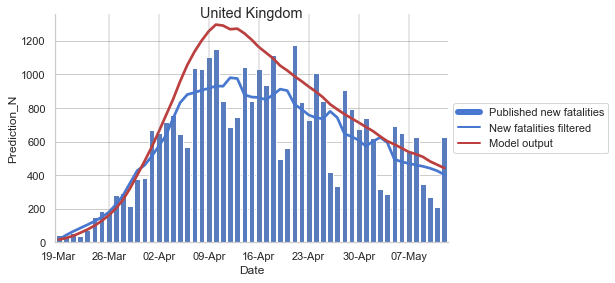

In [886]:
g = sns.FacetGrid(toPrint, height=4, aspect=2)#, hue='Country')#, col="United Kingdom")  legend_out = True,
g = g.map(sns.barplot, 'Date', 'dDeaths', color='#4777CE', order=None)#, hue='Country'
g = g.map(sns.pointplot, 'Date', 'dDeaths_filtered', markers="", color='#4777CE', order=None)
g = g.map(sns.pointplot, 'Date', 'Prediction_N', markers="", color="#bb3f3f", order=None)#.add_legend()
#g.add_legend()

#tickRange = range(0,max(toPrint['Day_0']),5)
#g.set(xticks=tickRange,xticklabels=tickRange)

tickRange = range(0,len(toPrint['Date_S']),7)
g.set(xticks=tickRange,xticklabels=toPrint['Date_S'].iloc[tickRange])


#Add vertical gridlines
for x in range(1,len(tickRange)):
    g.ax.axvline(g.ax.get_xticks()[x], alpha=0.25, color='grey')

g.fig.suptitle(chosenCountry)
custom_lines = [Line2D([0], [0], color='#4777CE', lw=6),
                Line2D([0], [0], color='#4777CE', lw=2),
                Line2D([0], [0], color="#bb3f3f", lw=2)]
plt.legend(custom_lines, ['Published new fatalities', 'New fatalities filtered', 'Model output'], 
           loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

/Applications/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


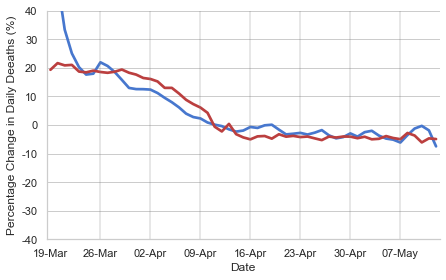

In [887]:
g = sns.FacetGrid(toPrint, height=4, aspect=2)#, hue='Country')#, col="United Kingdom")  legend_out = True,
#g = g.map(sns.barplot, 'Day_0', 'dDeaths', color='#4777CE')#, hue='Country'
g = g.map(sns.pointplot, 'Date', feature, markers="", color='#4777CE')
g = g.map(sns.pointplot, 'Date', 'Prediction', markers="", color="#bb3f3f")

tickRange = range(0,len(toPrint['Date_S']),7)
#tickRange = pd.date_range(min(toPrint['Date']),max(toPrint['Date']),freq='5D')
g.set(xticks=tickRange,xticklabels=toPrint['Date_S'].iloc[tickRange])
#g.ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO, interval=1))
# Get only the month to show in the x-axis:
#g.ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

#xtick_locator = mdates.AutoDateLocator()
#xtick_formatter = mdates.AutoDateFormatter(xtick_locator)

#g.ax.xaxis.set_major_locator(xtick_locator)
#g.ax.xaxis.set_major_formatter(xtick_formatter)
#g.ax.fmt_xdata = mdates.AutoDateFormatter('%Y-%m-%d')

#plt.yticks(g.ax.get_yticks(), g.ax.get_yticks() * 100)

g.set(ylim=(-.4, .4))
g.set(yticklabels = (np.around(g.ax.get_yticks() * 100).astype(int)))
plt.ylabel('Percentage Change in Daily Deeaths (%)')#, fontsize=16)

#g.axes.xaxis.set_major_locator(ticker.MultipleLocator(5))
for x in range(1,len(tickRange)):
    g.ax.axvline(g.ax.get_xticks()[x], alpha=0.25, color='grey')

plt.show()

In [888]:
G_features = ["Retail and Recreation", "Grocery and Pharmacy", "Parks", "Transit Stations", "Workplaces", "Residential"]
core_features = ['Country', 'Date', 'Day_0']

toPrintG = pd.DataFrame(columns = core_features)

toPrintG['Google Mobility Indicator'] = np.nan
toPrintG['% Change from baseline'] = np.nan

#for x in G_features
#toPrintG.loc[:,core_features] = toPrint.loc[:,core_features].reset_index(drop=True)#, inplace=True)
for x in G_features:
    
    currentLen = len(toPrintG)
    #print(toPrintG)
    
    toPrintG = toPrintG.append(df_output.loc[:,core_features].reset_index(drop=True), sort=False).reset_index(drop=True)
    toPrintG.loc[currentLen:,'Google Mobility Indicator'] = x
    toPrintG.loc[currentLen:,'% Change from baseline'] = df_output[x][:].values #toPrint.loc[:,x].reset_index(drop=True)

#    toPrintG = toPrintG.append(toPrint, sort=False, ignore_index=True)
#toPrint.loc[:,core_features].reset_index(drop=True)#, inplace=True)
#toPrintG.loc[200,:]
#toPrintG

/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


Text(0.5, 0.98, 'United Kingdom')

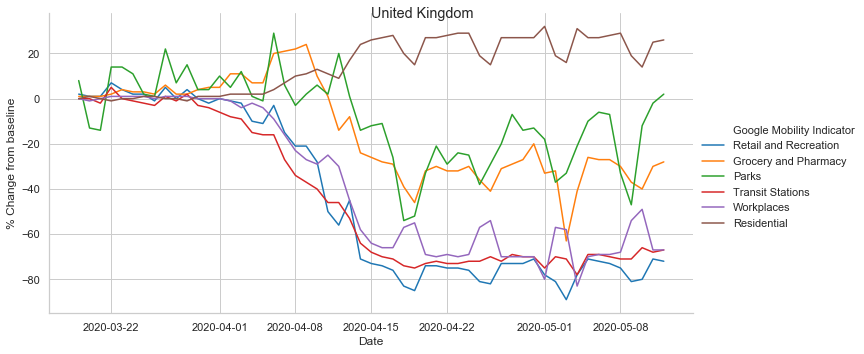

In [889]:
g = sns.relplot(x='Date', y='% Change from baseline', markers="", hue='Google Mobility Indicator', kind='line', estimator=None, aspect = 2, data = toPrintG[toPrintG.Country == chosenCountry])
g.fig.suptitle(chosenCountry)

# Prediction

In [890]:
a = df_output['dd_Deaths_f/dDeaths_f'][-dayOffset:].mean()*100
print('In the past 3 weeks, the average daily percentage percentage change in death is ' + str(a) + '%')

b = df_output['Prediction'][-dayOffset:].mean()*100
print('The ML model predicts ' + str(b) + '%')

In the past 3 weeks, the average daily percentage percentage change in death is -3.4190790323817235%
The ML model predicts -4.410479908310197%


In [891]:
googleCountryData = dfG_offset[dfG_offset['Country'] == chosenCountry].reset_index(drop=True)
JHCountryData = df_output[df_output['Country'] == chosenCountry].reset_index(drop=True)


Xp = scaler.transform(googleCountryData.drop(columns = ['Date', 'Country']))
Yp = model.predict(Xp)

In [892]:
Prediction = pd.DataFrame()#'Prediction', 'Date')
Prediction['Prediction'] = Yp
Prediction['Date'] = googleCountryData['Date']

PredictionC = Prediction.copy()

#Merging removes all dates not in both datasets (i.e. the prediction)
Prediction = pd.merge(Prediction, JHCountryData[['dd_Deaths_f/dDeaths_f', 'Date']], on=['Date']) 
Prediction = Prediction.rename(columns={'dd_Deaths_f/dDeaths_f': "Original"})

#So find the indexes of the future prediction
indexVal = np.where(PredictionC['Date'].values > Prediction['Date'][-1:].values)
#And append them back into the dataframe
Prediction  = Prediction.append(PredictionC.loc[indexVal[0],:], sort=False, ignore_index=True)

indexVal = np.where(googleCountryData['Date'].values > PredictionM['Date'][-1:].values)
PredictionM.append(Prediction.loc[temp,:], )

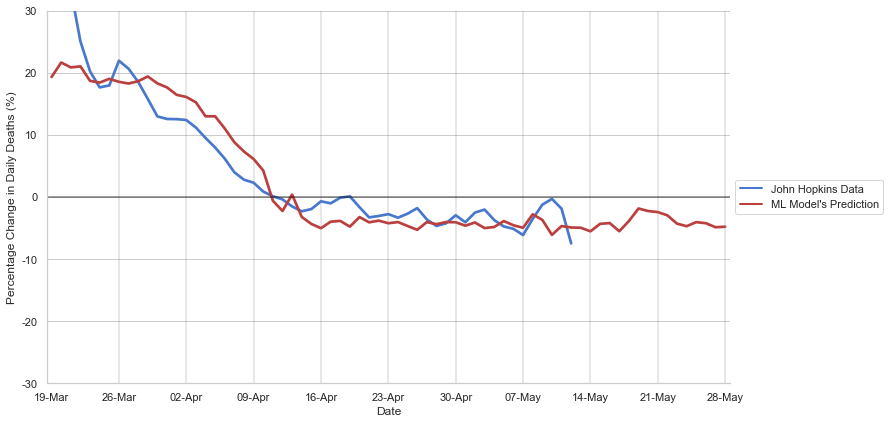

In [893]:
Prediction['Date_S'] = Prediction['Date'].dt.strftime("%d-%b")
g = sns.FacetGrid(Prediction, height=6, aspect=2)
g = g.map(sns.pointplot, 'Date', 'Original', markers="", color='#4777CE', order=None)
g = g.map(sns.pointplot, 'Date', 'Prediction', markers="", color="#bb3f3f", order=None)

tickRange = range(0,len(Prediction['Date_S']),7)

g.set(xticks=tickRange,xticklabels=Prediction['Date_S'].iloc[tickRange])

g.set(ylim=(-.3, .3))
g.set(yticklabels = (np.around(g.ax.get_yticks() * 100).astype(int)))
plt.ylabel('Percentage Change in Daily Deaths (%)')#, fontsize=16)

#Manually add vertical gridlines
for x in range(1,len(tickRange)):
    g.ax.axvline(g.ax.get_xticks()[x], alpha=0.25, color='grey')

#Add a black line for y=0 to make it clearer
x = np.where(g.ax.get_yticks() == 0)
g.ax.axhline(g.ax.get_yticks()[x], alpha=0.5, color='black')


#Add legend
custom_lines = [Line2D([0], [0], color='#4777CE', lw=2),
                Line2D([0], [0], color="#bb3f3f", lw=2)]
plt.legend(custom_lines, ['John Hopkins Data', "ML Model's Prediction"], loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [894]:
#To calculate predicted average daily change of deaths, first calculate the index of the last JH datapoint 
latestJHDate = np.where(Prediction['Date'].values == JHCountryData['Date'][-1:].values)

c = Prediction['Prediction'][latestJHDate[0][0]:].mean()*100
print('The ML model predicts ' + str(b) + '% since the most recent John Hopkins data point')

The ML model predicts -4.410479908310197% since the most recent John Hopkins data point


In [895]:
Prediction.loc[:,'per Day'] = np.nan
Prediction.loc[:,'Change per Day'] = np.nan

#df_output.loc[:,'Prediction_Total'] = np.nan


#for a in df_output['Country'].unique():
temp = df_output[df_output['Country'] == chosenCountry].reset_index(drop=True)

#    if feature == 'dd_Deaths_f/dDeaths_f':

Prediction.loc[0, 'per Day'] = temp.dDeaths_filtered.iloc[0]
Prediction.loc[0,'Change per Day'] = Prediction.loc[0, 'Prediction'] * Prediction.loc[0, 'per Day']

calc = pd.DataFrame()

for x in Prediction.index[1:]:
   
    Prediction.loc[x,'per Day'] = abs(Prediction.loc[x-1,'per Day'] / (1 - Prediction.loc[x,'Prediction']))

#for x in Prediction.index[1:]:

#    if x < dayOffset:
#        Prediction.loc[x,'per Day'] = Prediction.loc[x-1,'per Day'] / (1 - Prediction.loc[x,'Prediction'])
#    else:
#        calc.loc[x-dayOffset, 'per Day'] = temp.dDeaths_filtered.iloc[x-dayOffset]

#        for y in range(x-dayOffset+1,x+1):

#            calc.loc[y,'per Day'] = calc.loc[y-1,'per Day'] / (1 - Prediction.loc[y,'Prediction'])

        #x should equal y...
#        Prediction.loc[x,'per Day'] = calc.loc[x,'per Day']

In [896]:
Prediction['Raw per Day'] = temp['dDeaths']
Prediction['Original per Day'] = temp['dDeaths_filtered']

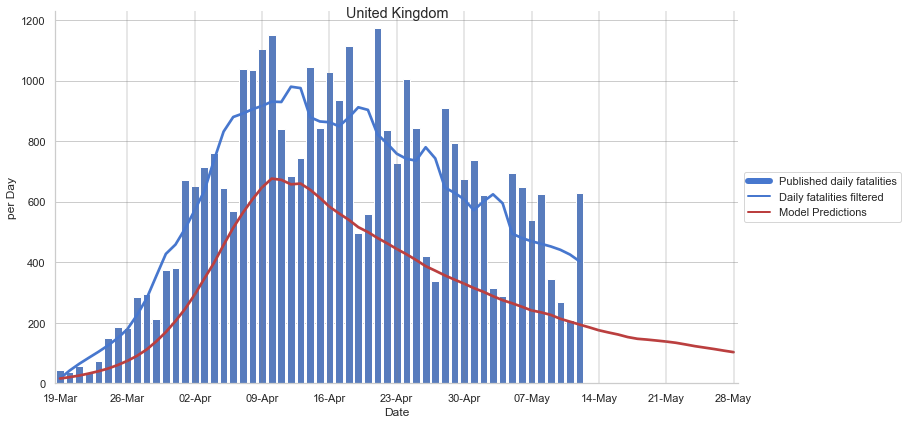

In [897]:
g = sns.FacetGrid(Prediction, height=6, aspect=2)#, hue='Country')#, col="United Kingdom")  legend_out = True,
g = g.map(sns.barplot, 'Date', 'Raw per Day', color='#4777CE', order=None)#, hue='Country'
g = g.map(sns.pointplot, 'Date', 'Original per Day', markers="", color='#4777CE', order=None)
g = g.map(sns.pointplot, 'Date', 'per Day', markers="", color="#bb3f3f", order=None)#.add_legend()
#g.add_legend()

#tickRange = range(0,max(toPrint['Day_0']),5)
#g.set(xticks=tickRange,xticklabels=tickRange)

tickRange = range(0,len(Prediction['Date_S']),7)
g.set(xticks=tickRange,xticklabels=Prediction['Date_S'].iloc[tickRange])


#Add vertical gridlines
for x in range(1,len(tickRange)):
    g.ax.axvline(g.ax.get_xticks()[x], alpha=0.25, color='grey')

g.fig.suptitle(chosenCountry)
custom_lines = [Line2D([0], [0], color='#4777CE', lw=6),
                Line2D([0], [0], color='#4777CE', lw=2),
                Line2D([0], [0], color="#bb3f3f", lw=2)]
plt.legend(custom_lines, ['Published daily fatalities', 'Daily fatalities filtered', 'Model Predictions'],
           loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

Text(32.94855000000001, 0.5, 'Deaths per day')

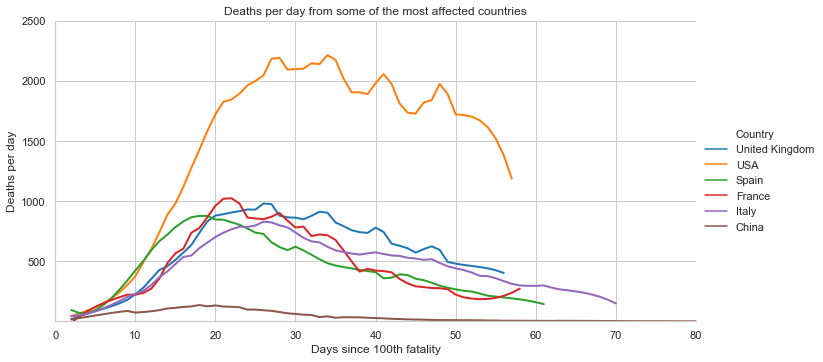

In [907]:
key = ['United Kingdom', 'USA', 'Spain', 'France', 'Italy' ,  'China']
#China is included in this list as it was the first country to be effected by COVID-19 

g = sns.relplot('Day_100', 'dDeaths_filtered', kind='line', estimator=None, hue = 'Country', hue_order = key, data = dfJ, aspect = 2, lw=2)# color='#4777CE', order=None)
#plt.yscale('log')
g.set(xlim=(0, 70))
g.set(ylim=(1, 2500))
plt.title('Deaths per day from some of the most affected countries')
plt.xlabel('Days since 100th fatality')
plt.ylabel('Deaths per day')

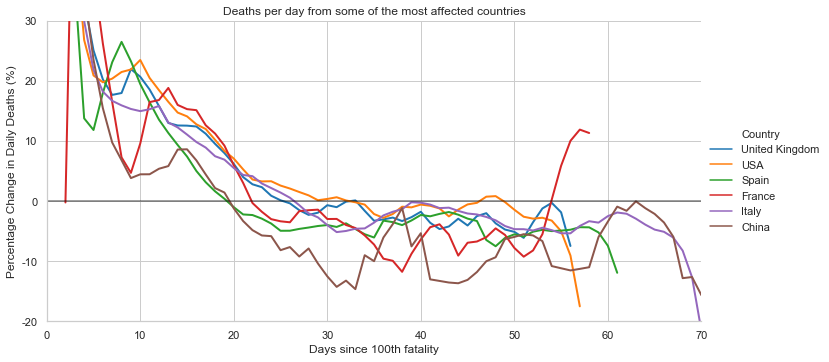

In [911]:
key = ['United Kingdom', 'USA', 'Spain', 'France', 'Italy' ,  'China']
#China is included in this list as it was the first country to be effected by COVID-19 

g = sns.relplot('Day_100', 'dd_Deaths_f/dDeaths_f', kind='line', estimator=None, hue = 'Country', hue_order = key, data = dfJ, aspect = 2, lw=2)# color='#4777CE', order=None)
#plt.yscale('log')
g.set(xlim=(0, 70))
g.set(ylim=(-.2, .3))
plt.title('Deaths per day from some of the most affected countries')
plt.xlabel('Days since 100th fatality')

g.set(yticklabels = (np.around(g.ax.get_yticks() * 100).astype(int)))
plt.ylabel('Percentage Change in Daily Deaths (%)')#, fontsize=16)

#Add a black line for y=0 to make it clearer
x = np.where(g.ax.get_yticks() == 0)
g.ax.axhline(g.ax.get_yticks()[x], alpha=0.5, color='black')
